- Installation

In [ ]:
%pip install git+https://github.com/Louis-Li-dev/ML_tool_kit
# %pip install torch
# %pip install numpy
# %pip install matplotlib
# %pip install tqdm

- Resolve Paths

In [10]:

import os
import sys
BASE_DIR = os.getcwd()
parent_dir = os.path.join(BASE_DIR, '..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

- Import Packages

In [11]:
import torch
import torch.nn as nn
import torchvision
from mkit.torch_support.nn_utils import training_loop
from mkit.torch_support.model.Autoencoder import GANEncoder
from mkit.torch_support.model.CNN import AdjustableCNN
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

- Use MNIST Data

In [12]:
NUM_OF_CLASSES = 10
WIDTH, HEIGHT = 28, 28

In [13]:

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Download and load the training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Download and load the test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



- Inherit a model

In [14]:

class Predictor(nn.Module):
    def __init__(self, width, height, hidden_dims, output_dim):
        """
        Predictor class with GANEncoder and fully connected layers for prediction.

        Args:
            hidden_dims (list[int]): List of dimensions for convolutional layers in GANEncoder.
            output_dim (int): Dimension of the prediction output.
        """
        super(Predictor, self).__init__()
        
        # Encoder
        self.encoder = GANEncoder(hidden_dims=hidden_dims)
        
        # Fully connected layers for prediction
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dims[-1] * width * height, 128),  # From the last encoder dimension to 128
            nn.ReLU(),
            nn.Linear(128, 64),              # From 128 to 64
            nn.ReLU(),
            nn.Linear(64, output_dim)        # From 64 to output dimension
        )

    def forward(self, x):
        """
        Forward pass for the predictor.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Prediction output.
        """
        x = self.encoder(x)  # Pass through the encoder
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)  # Pass through the fully connected layers
        return x

- Training

In [15]:


x, y = next(iter(train_loader))

model = Predictor(width=WIDTH, height=HEIGHT, hidden_dims=[1, 16], output_dim=NUM_OF_CLASSES)
device = torch.device('cuda')

criterion = torch.nn.CrossEntropyLoss()

In [16]:

model, losses = training_loop(
    model=model, 
    device=device,
    train_loader=train_loader,
    optimizer=torch.optim.Adam(model.parameters()),
    criterion=criterion,
    keep_losses=True,
)

EPOCH 1/5: 100%|██████████| 938/938 [00:40<00:00, 23.38it/s]


Epoch [1/5] Training Loss: 0.2764 

EPOCH 2/5: 100%|██████████| 938/938 [00:39<00:00, 23.59it/s]


Epoch [2/5] Training Loss: 0.1121 

EPOCH 3/5: 100%|██████████| 938/938 [00:39<00:00, 23.52it/s]


Epoch [3/5] Training Loss: 0.0766 

EPOCH 4/5: 100%|██████████| 938/938 [00:39<00:00, 23.59it/s]


Epoch [4/5] Training Loss: 0.0588 

EPOCH 5/5: 100%|██████████| 938/938 [00:39<00:00, 23.56it/s]

Epoch [5/5] Training Loss: 0.0471 Training complete.


- Evaluation

In [17]:

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

average_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4%}')
    

100%|██████████| 157/157 [00:05<00:00, 26.45it/s]

Average Loss: 0.0788, Accuracy: 97.6800%


- Case Study

Predictions: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]
True Labels:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


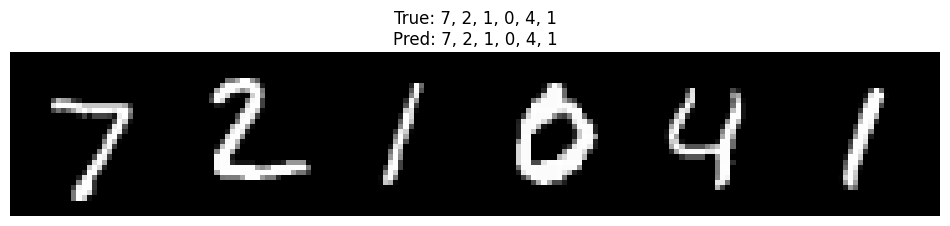

In [18]:
# Get a batch of test data
test_x, test_y = next(iter(test_loader))

# Move the input data to the device (e.g., 'cuda' or 'cpu')
test_x = test_x.to(device)

# Forward pass: Get model predictions
predictions = torch.argmax(model(test_x), dim=1)  # Get the class with the highest score

# Compare predictions with true labels
print("Predictions:", predictions.cpu().numpy())  # Convert predictions to NumPy array for readability
print("True Labels: ", test_y.numpy())  # Convert true labels to NumPy array


def show_predictions(images, true_labels, predicted_labels, num_images=6):
    """
    Display a grid of images with their true and predicted labels.
    """
    images = images[:num_images]  # Select the first `num_images`
    true_labels = true_labels[:num_images]
    predicted_labels = predicted_labels[:num_images]

    # Create a grid of images
    grid = torchvision.utils.make_grid(images, nrow=num_images, padding=2, normalize=True)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # Convert to NumPy for plotting

    # Plot the grid of images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid)
    plt.title("True: " + ", ".join(str(label.item()) for label in true_labels) +
              "\nPred: " + ", ".join(str(label.item()) for label in predicted_labels))
    plt.axis('off')
    plt.show()

# Call the helper function
show_predictions(test_x.cpu(), test_y, predictions.cpu(), num_images=6)


# Use CNN

In [19]:
model = AdjustableCNN(
    input_channels=1,
    num_filters = [1, 16],
    normalization="batch",
    width=28,
    height=28
)

model = training_loop(
    model,
    device,
    train_loader,
    torch.optim.Adam(model.parameters()),
    nn.CrossEntropyLoss(),
)

EPOCH 1/5: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s]


Epoch [1/5] Training Loss: 0.3049 

EPOCH 2/5: 100%|██████████| 938/938 [00:37<00:00, 24.90it/s]


Epoch [2/5] Training Loss: 0.1314 

EPOCH 3/5: 100%|██████████| 938/938 [00:37<00:00, 25.13it/s]


Epoch [3/5] Training Loss: 0.1044 

EPOCH 4/5: 100%|██████████| 938/938 [00:35<00:00, 26.24it/s]


Epoch [4/5] Training Loss: 0.0907 

EPOCH 5/5: 100%|██████████| 938/938 [00:36<00:00, 26.04it/s]

Epoch [5/5] Training Loss: 0.0822 Training complete.


In [20]:

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

average_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4%}')
    

100%|██████████| 157/157 [00:05<00:00, 29.82it/s]

Average Loss: 0.0802, Accuracy: 97.3300%


Predictions: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 5 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]
True Labels:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


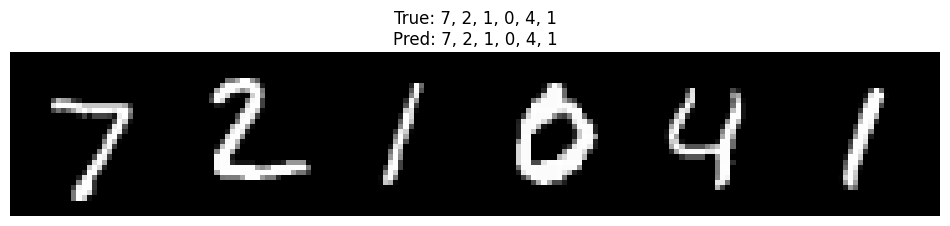

In [21]:
# Get a batch of test data
test_x, test_y = next(iter(test_loader))

# Move the input data to the device (e.g., 'cuda' or 'cpu')
test_x = test_x.to(device)

# Forward pass: Get model predictions
predictions = torch.argmax(model(test_x), dim=1)  # Get the class with the highest score

# Compare predictions with true labels
print("Predictions:", predictions.cpu().numpy())  # Convert predictions to NumPy array for readability
print("True Labels: ", test_y.numpy())  # Convert true labels to NumPy array


def show_predictions(images, true_labels, predicted_labels, num_images=6):
    """
    Display a grid of images with their true and predicted labels.
    """
    images = images[:num_images]  # Select the first `num_images`
    true_labels = true_labels[:num_images]
    predicted_labels = predicted_labels[:num_images]

    # Create a grid of images
    grid = torchvision.utils.make_grid(images, nrow=num_images, padding=2, normalize=True)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # Convert to NumPy for plotting

    # Plot the grid of images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid)
    plt.title("True: " + ", ".join(str(label.item()) for label in true_labels) +
              "\nPred: " + ", ".join(str(label.item()) for label in predicted_labels))
    plt.axis('off')
    plt.show()

# Call the helper function
show_predictions(test_x.cpu(), test_y, predictions.cpu(), num_images=6)
